In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score


In [2]:
voice_clip_meta_data = pd.read_csv("voice_clip_meta_data.csv")
audiofile = [
    "common_voice_en_487076.mp3", "common_voice_en_20661764.mp3",
    "common_voice_en_1716.mp3", "common_voice_en_20002554.mp3",
    "common_voice_en_30282850.mp3", "common_voice_en_39750682.mp3",
    "common_voice_en_37110064.mp3", "common_voice_en_31267867.mp3"
]

data_dir = 'C:/Users/lukeh/OneDrive/Documents/College/Topics in Data Science/Unit 2/voice_clip_selected'

os.environ["OMP_NUM_THREADS"] = "1"

In [3]:
def extract_features(file_path):
    """Extracts features from an audio file using librosa."""
    y, sr = librosa.load(file_path, sr=None)
    
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1)
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr), axis=1)
    tonnetz = np.mean(librosa.feature.tonnetz(y=y, sr=sr), axis=1)
    
    features = np.concatenate((mfcc, chroma, spectral_contrast, tonnetz))
    return features

In [4]:
features_list = []
for file in audiofile:
    file_path = f"{data_dir}/{file}"
    features = extract_features(file_path)
    features_list.append(features)

voice_features = pd.DataFrame(features_list)


In [5]:
def find_elbow(features_df, clusters_range):
    """Finds the optimal number of clusters using the elbow method."""
    stscaler = StandardScaler().fit(features_df)
    normalized_df = stscaler.transform(features_df)

    inertias = []  
    for k in clusters_range:
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=100, max_iter=300, random_state=0)
        kmeans.fit(normalized_df)
        inertias.append(kmeans.inertia_)

    plt.figure()
    plt.plot(clusters_range, inertias, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of clusters: k')
    plt.ylabel('Inertia')
    plt.show()

C:\Users\lukeh\Downloads\Anaconda3\envs\voice\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\lukeh\Downloads\Anaconda3\envs\voice\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\lukeh\Downloads\Anaconda3\envs\voice\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\lukeh\Downloads\Anaconda3\envs\voice\Lib\site-packages\sklearn\c

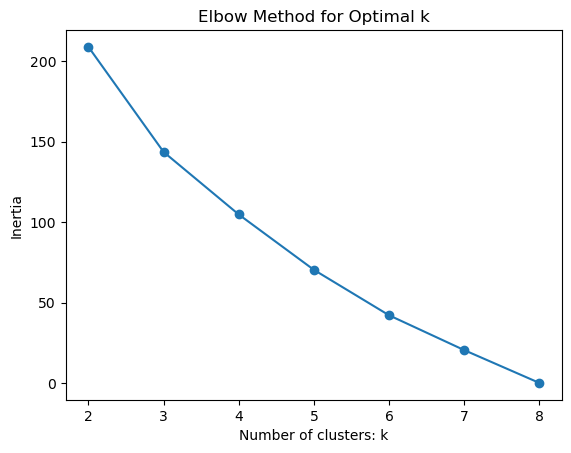

In [6]:
clusters_range = list(range(2, 9))
find_elbow(voice_features, clusters_range)

Althought there is not an exactly clear elbow point from the figure, the best guess from looking at it could be at k=2.

In [7]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1)
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr), axis=1)
    tonnetz = np.mean(librosa.feature.tonnetz(y=y, sr=sr), axis=1)
    return mfcc, chroma, spectral_contrast, tonnetz

features = [extract_features(f"{data_dir}/{file}") for file in audiofile]
feature_dict = {
    'MFCC': np.array([feat[0] for feat in features]),
    'Chroma': np.array([feat[1] for feat in features]),
    'Spectral': np.array([feat[2] for feat in features]),
    'Tonnetz': np.array([feat[3] for feat in features]),
    'Full': np.hstack([np.array([feat[i] for feat in features]) for i in range(4)])
}

scaler = StandardScaler()
scaled_features = {key: scaler.fit_transform(value) for key, value in feature_dict.items()}

def cluster_with_methods(data, method='kmeans', clusters=3):
    if method == 'kmeans':
        model = KMeans(n_clusters=clusters, n_init=100, max_iter=300, random_state=0)
    elif method == 'agglomerative':
        model = AgglomerativeClustering(n_clusters=clusters)
    elif method == 'dbscan':
        model = DBSCAN(eps=0.5, min_samples=2)
    else:
        raise ValueError("Unsupported clustering method")

    labels = model.fit_predict(data)
    if len(set(labels)) > 1:  # Check for non-singleton clusters
        silhouette = silhouette_score(data, labels)
    else:
        silhouette = None
    return labels, silhouette

results = []
for subset, data in scaled_features.items():
    for method in ['kmeans', 'agglomerative', 'dbscan']:
        for k in range(2, 5):  # Try 2 to 4 clusters for KMeans and Agglomerative
            if method == 'dbscan' and k != 2:
                continue  # Skip non-applicable cluster counts for DBSCAN
            labels, silhouette = cluster_with_methods(data, method, clusters=k)
            results.append((subset, method, k, silhouette))

results_df = pd.DataFrame(results, columns=['Feature Subset', 'Method', 'Clusters (k)', 'Silhouette Score'])
results_df = results_df.sort_values(by=['Feature Subset', 'Silhouette Score'], ascending=[True, False])

results_df  

C:\Users\lukeh\Downloads\Anaconda3\envs\voice\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\lukeh\Downloads\Anaconda3\envs\voice\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\lukeh\Downloads\Anaconda3\envs\voice\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\lukeh\Downloads\Anaconda3\envs\voice\Lib\site-packages\sklearn\c

,Feature Subset,Method,Clusters (k),Silhouette Score
7,Chroma,kmeans,2,0.287565
10,Chroma,agglomerative,2,0.287565
9,Chroma,kmeans,4,0.218123
12,Chroma,agglomerative,4,0.218123
8,Chroma,kmeans,3,0.211406
11,Chroma,agglomerative,3,0.211406
13,Chroma,dbscan,2,NaN
29,Full,kmeans,3,0.172333
32,Full,agglomerative,3,0.172333
28,Full,kmeans,2,0.161018


### Conclusion
* The analysis shows that clustering on the Tonnetz feature subset with 2 clusters gives the highest silhouette score, indicating the clearest separation between clusters. Spectral features also perform reasonably well with 2 clusters but are less distinct than Tonnetz. Combining all features (the Full subset) does not significantly improve clustering quality, suggesting that Tonnetz and Spectral subsets individually capture the most useful clustering information. DBSCAN was not effective for this dataset, as it could not identify meaningful clusters.